In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, metrics,layers, models
from tensorflow.keras import backend as K
from keras import Model

In [6]:
# Downloading dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [7]:
# Preprocess images
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values = 0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [10]:
# Encoder
encoder_input = layers.Input(shape = (32,32,1), name = "encoder_input")

x = layers.Conv2D(32, (3,3), strides = 2, activation = "relu", padding = "same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding = "same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name = "encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output, name = "encoder")

In [11]:
# Decoder
decoder_input = layers.Input(shape = (2,), name = "decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation = 'relu', padding="same")(x)

decoder_output = layers.Conv2D(1,(3, 3),strides = 1,activation="sigmoid",padding="same",name="decoder_output")(x)

decoder = models.Model(decoder_input, decoder_output, name = "decoder")

In [12]:
# Combined autoencoder
autoencoder = Model(encoder_input, decoder(encoder_output), name = "autoencoder")

In [13]:
# Compilation
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [14]:
# Training
autoencoder.fit(x_train,x_train,epochs=20,batch_size=100,shuffle=True,validation_data=(x_test, x_test))

Epoch 1/20
600/600 [==============================] - 13s 10ms/step - loss: 0.1862 - val_loss: 0.1566
Epoch 2/20
600/600 [==============================] - 5s 9ms/step - loss: 0.1514 - val_loss: 0.1476
Epoch 3/20
600/600 [==============================] - 6s 10ms/step - loss: 0.1461 - val_loss: 0.1440
Epoch 4/20
600/600 [==============================] - 6s 10ms/step - loss: 0.1432 - val_loss: 0.1421
Epoch 5/20
600/600 [==============================] - 6s 10ms/step - loss: 0.1413 - val_loss: 0.1408
Epoch 6/20
600/600 [==============================] - 6s 10ms/step - loss: 0.1398 - val_loss: 0.1389
Epoch 7/20
600/600 [==============================] - 6s 10ms/step - loss: 0.1386 - val_loss: 0.1393
Epoch 8/20
600/600 [==============================] - 7s 11ms/step - loss: 0.1377 - val_loss: 0.1378
Epoch 9/20
600/600 [==============================] - 7s 12ms/step - loss: 0.1369 - val_loss: 0.1369
Epoch 10/20
600/600 [==============================] - 7s 11ms/step - loss: 0.1361 - val_lo

1/1 [==============================] - 1s 753ms/step


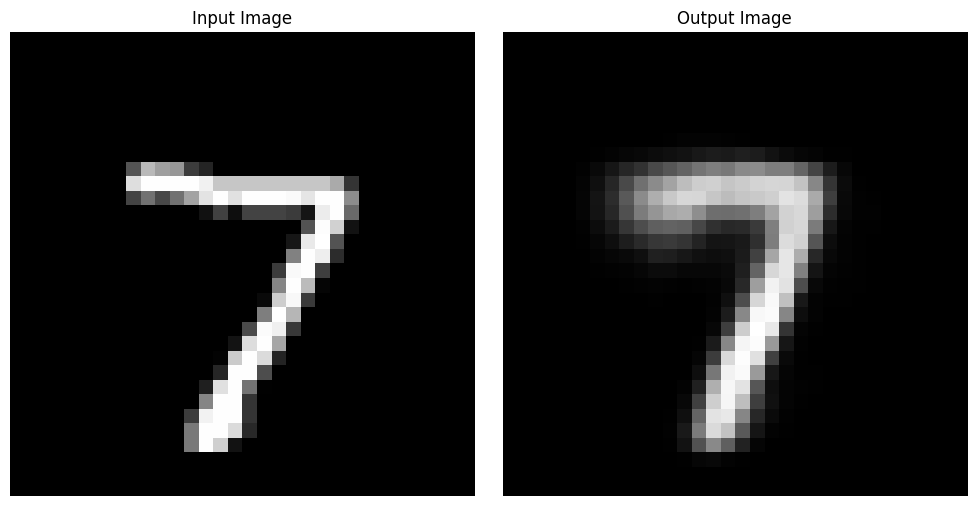

In [15]:
# Visualising Autoencoder's Prediction
example_image = x_test[:1]
prediction = autoencoder.predict(example_image)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(example_image[0], cmap="gray")
axes[0].set_title("Input Image")
axes[0].axis('off')


axes[1].imshow(prediction[0], cmap="gray")
axes[1].set_title("Output Image")
axes[1].axis('off')


plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 2ms/step


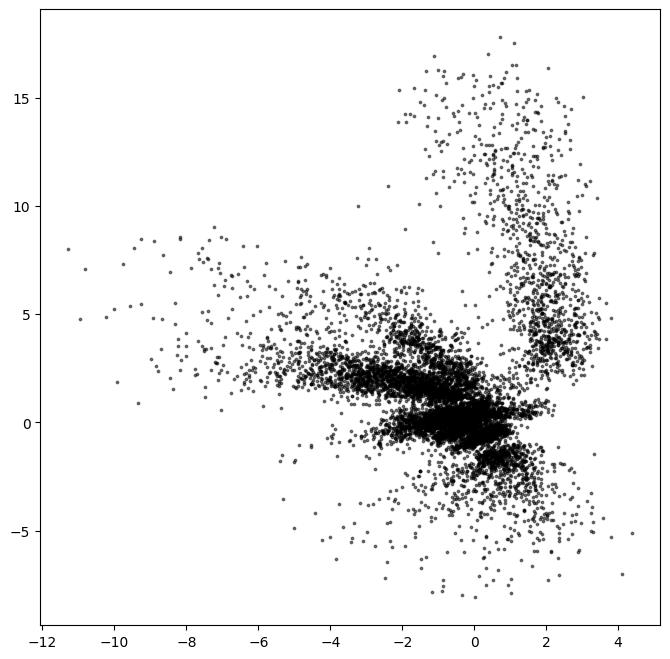

In [16]:
# Visualising latent space
latent_space = encoder.predict(x_test[:])
plt.figure(figsize = (8,8))

plt.scatter(latent_space[:, 0], latent_space[:, 1], c = "black", alpha = 0.5, s = 3)

plt.show()

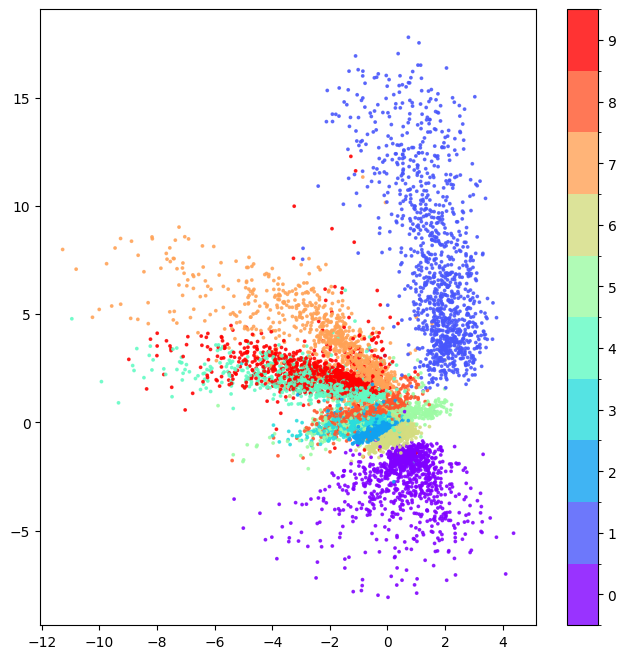

In [17]:
# Visualising latent space with colors
from matplotlib.colors import ListedColormap, BoundaryNorm

labels = y_test[:]
unique_labels = np.unique(labels)

colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(len(unique_labels) + 1) - 0.5, len(unique_labels))

plt.figure(figsize=(8, 8))

plt.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    cmap=cmap,
    norm=norm,
    c=labels,
    alpha=0.8,
    s=3,
)

plt.colorbar(ticks=np.arange(len(unique_labels)), values=unique_labels)
plt.show()

1/1 [==============================] - 0s 188ms/step


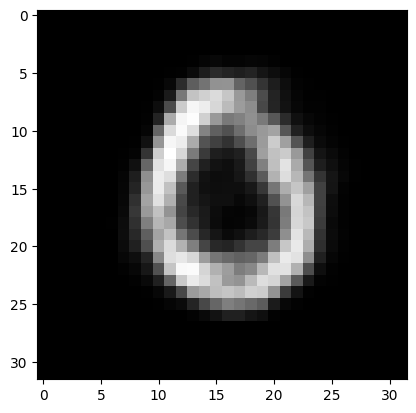

In [18]:
# Random Sampling from Latent space
random_image = decoder.predict([[0, -1.5]])

plt.imshow(random_image[:][0], cmap = "gray")

8/8 [==============================] - 0s 3ms/step


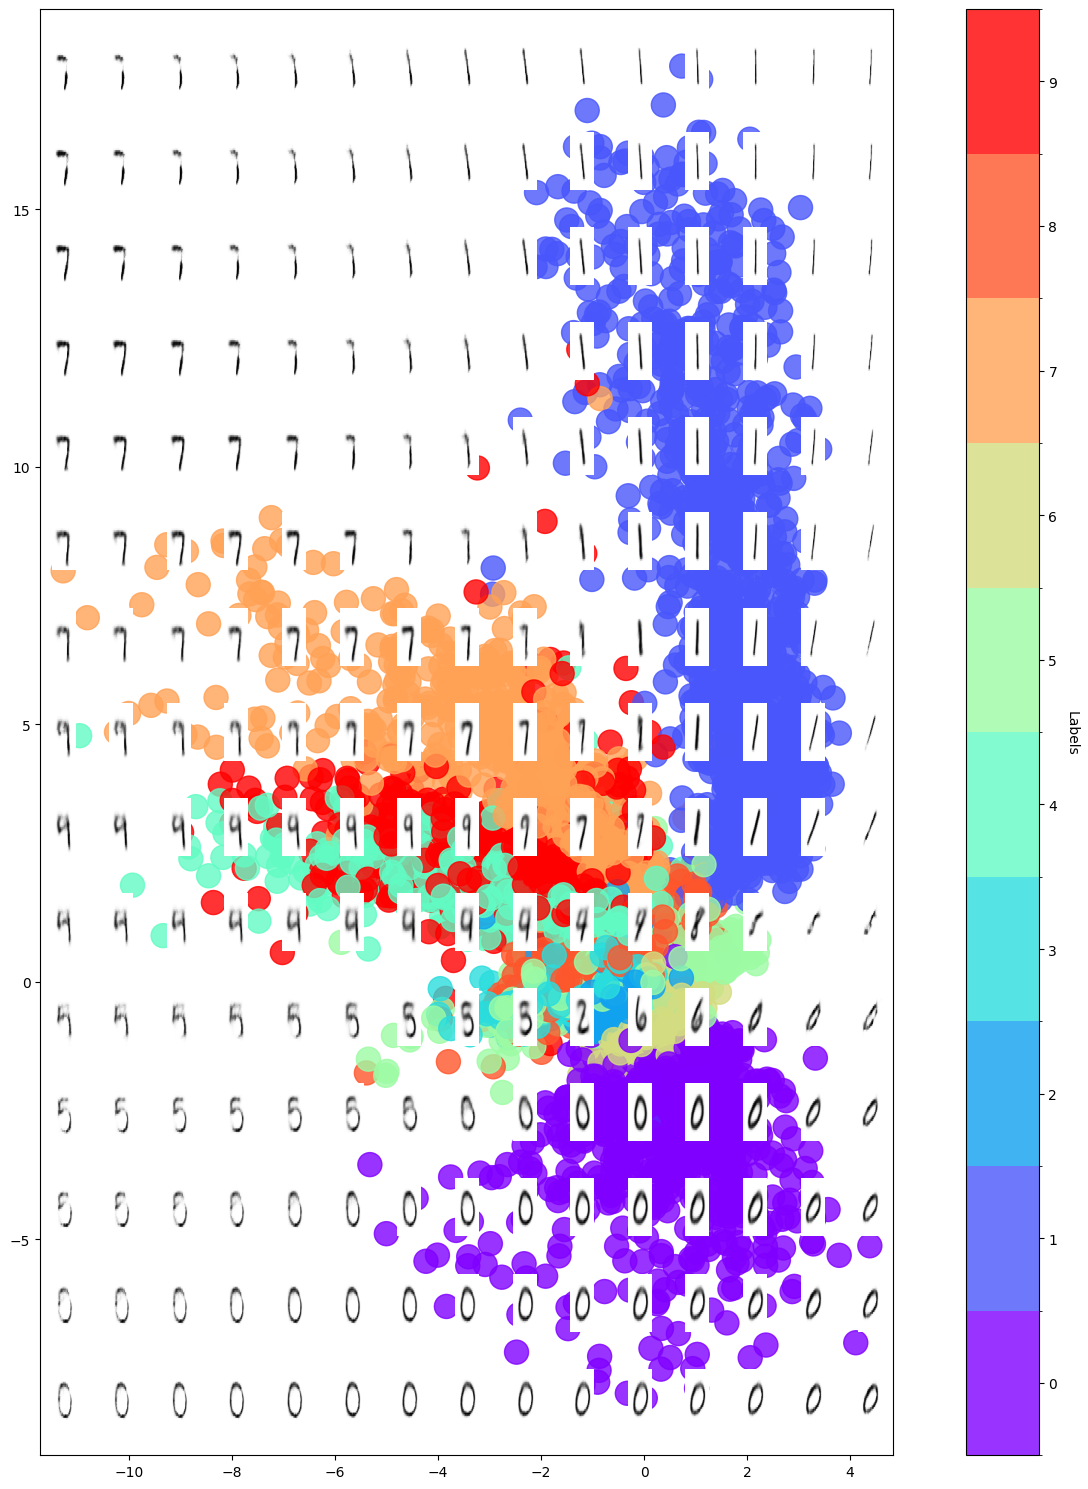

In [23]:
# Visualising all points in the latent space
figsize = 15
grid_size = 15

unique_labels = [i for i in range(10)]

colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(len(unique_labels) + 1) - 0.5, len(unique_labels))

fig, ax = plt.subplots(figsize=(figsize, figsize))

x_lim = (np.min(latent_space[:, 0]), np.max(latent_space[:, 0]))
y_lim = (np.min(latent_space[:, 1]), np.max(latent_space[:, 1]))

x = np.linspace(x_lim[0], x_lim[1], grid_size)
y = np.linspace(y_lim[1], y_lim[0], grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)

width = (x[1] - x[0]) * 0.4
height = (y[0] - y[1]) * 0.6

for i in range(grid_size**2):
    x_pos = grid[i, 0] - width / 2
    y_pos = grid[i, 1] - height / 2
    ax.imshow(reconstructions[i, :, :].reshape(reconstructions[i].shape[:-1]), cmap="Greys",
              extent=(x_pos, x_pos + width, y_pos, y_pos + height), zorder=2)  # set a higher zorder

scatter = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    cmap=cmap,
    norm=norm,
    c=labels,
    alpha=0.8,
    s=300,
    zorder=1
)

cbar = plt.colorbar(scatter, ticks=np.arange(len(unique_labels)), ax=ax)
cbar.set_label('Labels', rotation=270, labelpad=15)

ax.set_xlim(x_lim[0] - width, x_lim[1] + width)
ax.set_ylim(y_lim[0] - height, y_lim[1] + height)

plt.tight_layout()
plt.show()